# Spaceship Titanic, Kaggle educational competition
#### EDA and XGBoost or CatBoost model
Kaggle link:  https://www.kaggle.com/competitions/spaceship-titanic

## Import 

In [1]:
import numpy as np
import pandas as pd 

pd.options.mode.chained_assignment = None

## Reading data

In [2]:
X_train_full = pd.read_csv("./data/train.csv")
X_test_full = pd.read_csv("./data/test.csv")
X_EDA = X_train_full.copy()

In [3]:
X_train_full.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
4640,4941_01,Mars,False,F/1008/P,TRAPPIST-1e,35.0,False,988.0,0.0,830.0,2.0,0.0,Waffes Buche,False
7292,7800_01,Earth,True,G/1251/P,TRAPPIST-1e,15.0,False,0.0,0.0,NaN,0.0,0.0,Alvira Potterry,True
6104,6446_02,Earth,True,G/1047/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Nelley Yatters,True
5892,6246_01,Mars,False,F/1199/S,TRAPPIST-1e,28.0,False,NaN,0.0,129.0,0.0,NaN,Barkix Nuthe,False
4854,5180_01,Earth,True,G/835/P,PSO J318.5-22,20.0,False,0.0,0.0,0.0,NaN,0.0,Felia Gillock,True


## EDA 

In [4]:
X_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
X_EDA.select_dtypes(["object"]).describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,6608_01,Earth,False,G/734/S,TRAPPIST-1e,False,Glena Hahnstonsen
freq,1,4602,5439,8,5915,8291,2


In [6]:
X_EDA.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
X_EDA.select_dtypes(["object"]).describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,6608_01,Earth,False,G/734/S,TRAPPIST-1e,False,Glena Hahnstonsen
freq,1,4602,5439,8,5915,8291,2


#### There are few empty values here, so this is not a big problem, I will fill them. 
#### Also, there are many columns that contain useful information, but they have to be processed for the model. For example, we have to separate such columns as PassengerId and Cabin.

PassengerId is represented as a group_id, we don't care about the number of the group or passenger, but we may need information about how many more people are in the group with each passenger, let's check if this affects the chance to be Transported

<AxesSubplot:xlabel='GroupSize'>

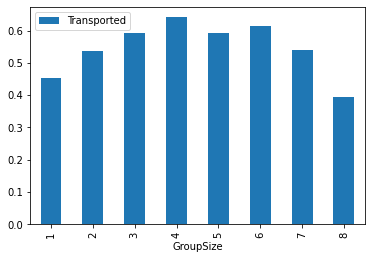

In [13]:
group_id = X_EDA.PassengerId.str.split("_", expand=True)[0].astype("int32")
group_sizes = group_id.value_counts().to_dict()
GroupSize = group_id.map(lambda x: group_sizes[x]).rename("GroupSize")
pd.concat([GroupSize, X_EDA.Transported], axis=1).groupby("GroupSize").mean().plot.bar()

As we can see people in medium-sized groups were more likely to survive than individuals and oversized groups

#### Lets try to find out does the home planet affect the chance of being transported

In [14]:
pd.DataFrame(X_EDA.groupby(["HomePlanet"])["Transported"].mean())

,Transported
HomePlanet,
Earth,0.423946
Europa,0.658846
Mars,0.523024


This is useful information, we will need it

#### Cabin represented here as Deck\num\side . And if num is ussless, it makes sense to use Deck and Side.

In [16]:
print("Raw value Cabin:")
print("-"*10)
print("num of unique:", end=' ')
print(X_EDA.Cabin.nunique())
print("*"*20)
print("Deck value:")
print("-"*10)
print("num of unique:", end=' ')
deck = X_EDA.Cabin.str.split("/", expand=True)[0].rename("Deck")
print(deck.nunique())
print("*"*20)
print("Side value:")
print("-"*10)
print("num of unique:", end=' ')
side = X_EDA.Cabin.str.split("/", expand=True)[2].rename("Side")
print(side.nunique())
print("*"*20)
deck = pd.concat([deck, X_EDA.Transported], axis=1)
side = pd.concat([side, X_EDA.Transported], axis=1)

Raw value Cabin:
----------
num of unique: 6560
********************
Deck value:
----------
num of unique: 8
********************
Side value:
----------
num of unique: 2
********************


It is logical to assume that Deck and SIde affect the chance to be Transported

In [17]:
print(deck.groupby("Deck")["Transported"].mean())
print("-"*20)
print(side.groupby("Side")["Transported"].mean())

Deck
A    0.496094
B    0.734275
C    0.680054
D    0.433054
E    0.357306
F    0.439871
G    0.516217
T    0.200000
Name: Transported, dtype: float64
--------------------
Side
P    0.451260
S    0.555037
Name: Transported, dtype: float64


#### Passengers in CryoSleep are more likely to be Transported

In [18]:
pd.DataFrame(X_EDA.groupby("CryoSleep")["Transported"].mean())

,Transported
CryoSleep,
False,0.328921
True,0.817583


#### It turns out that destination also affects the chance

In [20]:
X_EDA.groupby("Destination")["Transported"].mean()

Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64

#### Age can be a very important indicator in this case, you should look for dependencies here

age <= 18 chance:
0.6075067024128686
age 19-25 chance:
0.45150172328902016
age > 25 chance:
0.48462537895192725


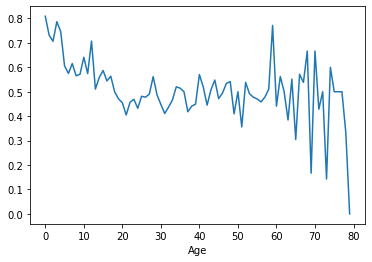

In [21]:
X_EDA.groupby("Age")["Transported"].mean().plot.line()
print("age <= 18 chance:")
print(X_EDA[X_EDA.Age.isin(range(0, 19))]["Transported"].mean())
print("age 19-25 chance:")
print(X_EDA[X_EDA.Age.isin(range(19, 26))]["Transported"].mean())
print("age > 25 chance:")
print(X_EDA[X_EDA.Age.isin(range(26, 100))]["Transported"].mean())

A few conclusions according to this chart:
Passengers under 18 are more likely to
 be transported
Ages 19-25 are less predisposed
Older people have about the same chances.
I think it makes sense to add a column with the indicator child, young or adult

#### VIPs have a much lower chance of being Transported

In [22]:
X_EDA.groupby("VIP").Transported.mean()

VIP
False    0.506332
True     0.381910
Name: Transported, dtype: float64

#### Creating new column which contains sum of spended money and looking for dependencies

In [23]:
X_EDA["MS"] = X_EDA[["RoomService","FoodCourt","ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
print("money spent = 0:")
print(X_EDA[X_EDA["MS"] == 0].Transported.mean())
print("money spent > 0:")
print(X_EDA[X_EDA["MS"] > 0].Transported.mean())

money spent = 0:
0.7864768683274022
money spent > 0:
0.2986111111111111


Passengers who have not spent money have a much higher chance of being transported

Correlation of spended money with target column

In [24]:
X_EDA[["RoomService","FoodCourt","ShoppingMall", "Spa", "VRDeck", "Transported"]].corr()["Transported"]

RoomService    -0.244611
FoodCourt       0.046566
ShoppingMall    0.010141
Spa            -0.221131
VRDeck         -0.207075
Transported     1.000000
Name: Transported, dtype: float64

Based on this data, we can see that there are two subcategories here, in one Spa, VRDeck and RoomService, in the other FoodCourt and ShoppingMall.
Perhaps the first subcategory could afford only more affluent passengers, so this dependence. It is reasonable not to combine all the columns into one, but to divide them into subcategories

## Preprocessing

#### Taking out the target column

In [25]:
y_train_full = X_train_full.Transported
y_train_full = y_train_full.map(lambda x: int(x))

In [26]:
X_train_full.drop(["Transported"], axis=1, inplace=True)

#### Custom Column Transformers for preprocessing data. The reasons for this processing are explained above.

In [86]:
class drop_name:
    def __init__(self):
        pass
    
    
    def transform(self, X, y=None):
        new_X = X.drop("Name", axis=1)
        return new_X
        
    
    def fit(self, X, y=None):
        return self

    

class object_to_num:
    
    def __init__(self):
        pass
    
    
    def transform(self, X, y=None):
        cryosleep = X.CryoSleep.astype("float32").rename("CryoSleep")
        vip = X.VIP.astype("float32").rename("VIP")
        new_X = pd.concat([X.drop(["CryoSleep", "VIP"], axis=1), cryosleep, vip], axis=1)
        return new_X
        
    
    def fit(self, X, y=None):
        return self
    
    
    
class id_transformer:
    def __init__(self):
        pass
        
    def transform(self, X, y=None):
        new_col = X["PassengerId"].str.split("_", expand=True)[0].astype("int32")
        group_sizes = new_col.value_counts().to_dict()
        new_col = new_col.map(lambda x: group_sizes[x]).rename("GroupSize")
        new_X = pd.concat([X.drop(["PassengerId"], axis=1), new_col], axis=1)
        return new_X
        
    
    def fit(self, X, y=None):
        return self
    
    
class cabin_to_deck_side_transformer:
    def __init__(self):
        pass
        
    def transform(self, X, y=None):
        Deck = X["Cabin"].str.split("/", expand=True)[0].rename("Deck")
        Side = X["Cabin"].str.split("/", expand=True)[2].rename("Side")
        new_X = pd.concat([X.drop("Cabin", axis=1), Deck, Side], axis=1)
        return new_X
    
    def fit(self, X, y=None):
        return self

class money_spent:
    def __init__(self):
        pass
        
    def transform(self, X, y=None):
        exp = ["RoomService", "Spa", "VRDeck"]
        inexp = ["FoodCourt", "ShoppingMall"]
        exp_col =  X[exp].sum(axis = 1).rename("ExpMS")
        inexp_col =  X[inexp].sum(axis = 1).rename("InexpMS")
        new_X = pd.concat([X.drop(inexp+exp, axis=1), exp_col, inexp_col], axis=1)
        return new_X
    
    def fit(self, X, y=None):
        return self
    
    
class age_category:
    
    def __init__(self):
        pass
    
    def __age_cat(self, age):
        if age <= 18:
            return "C"
        elif 18 < age < 26:
            return "Y"
        elif age >= 26:
            return "O"
        else:
            return None
        
    def transform(self, X, y=None):
        new_col = X.Age.apply(self.__age_cat).rename("AgeCat")
        new_X = pd.concat([X,new_col], axis=1)
        return new_X
    
    def fit(self, X, y=None):
        return self

#### Creating lists of columns depending on datatype

In [87]:
numeric_cols = list(X_train_full.select_dtypes(exclude=["object"]).columns)
obj_cols = list(X_train_full.select_dtypes(["object"]).columns)
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    numeric_cols.remove(col)
numeric_cols.append("ExpMS")
numeric_cols.append("InexpMS")
numeric_cols.append("VIP")
numeric_cols.append("CryoSleep")
numeric_cols.append("GroupSize")



obj_cols.remove('PassengerId')
obj_cols.remove('CryoSleep')
obj_cols.remove('VIP')
obj_cols.remove('Name')
obj_cols.remove('Cabin')
obj_cols.append("Deck")
obj_cols.append('Side')
obj_cols.append('AgeCat')



print(f'num_cols: {numeric_cols}')
print(f'obj_cols: {obj_cols}')

num_cols: ['Age', 'ExpMS', 'InexpMS', 'VIP', 'CryoSleep', 'GroupSize']
obj_cols: ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeCat']


#### Creating column transformers and Pipeline for preprocessing

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
import xgboost as xgb



num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
    
])

obj_transformer = Pipeline(steps=[
    ("obj_imputer", SimpleImputer(strategy="most_frequent")),
    ("OH_encoder", OneHotEncoder(handle_unknown='ignore'))
])


transformer = ColumnTransformer([
    ("num_transformer", num_transformer, numeric_cols),
    ("obj_transformer", obj_transformer, obj_cols)
])

preprocess = Pipeline(steps=[
    ("obj_to_num", object_to_num()),
    ("drop_name", drop_name()),
    ("replace_id_transformer", id_transformer()),
    ("cabin_transformer", cabin_to_deck_side_transformer()),
    ("money_spent_transformer", money_spent()),
    ("age_category", age_category()),
    ("col_transformer", transformer)
    
])



#### Splitting Training data  and creating my XGBoost model

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

X_train = preprocess.fit_transform(X_train)
X_valid = preprocess.transform(X_valid)
X_test = preprocess.transform(X_test_full)

model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder=False)

model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             eval_metric='logloss',
             verbose=True
         )

score = accuracy_score(y_valid, model.predict(X_valid))



[0]	validation_0-logloss:0.67123
[1]	validation_0-logloss:0.65127
[2]	validation_0-logloss:0.63344
[3]	validation_0-logloss:0.61699
[4]	validation_0-logloss:0.60196
[5]	validation_0-logloss:0.58812
[6]	validation_0-logloss:0.57537
[7]	validation_0-logloss:0.56372
[8]	validation_0-logloss:0.55312
[9]	validation_0-logloss:0.54324
[10]	validation_0-logloss:0.53429
[11]	validation_0-logloss:0.52559
[12]	validation_0-logloss:0.51775
[13]	validation_0-logloss:0.51045
[14]	validation_0-logloss:0.50392
[15]	validation_0-logloss:0.49736
[16]	validation_0-logloss:0.49118
[17]	validation_0-logloss:0.48553
[18]	validation_0-logloss:0.48055
[19]	validation_0-logloss:0.47593
[20]	validation_0-logloss:0.47154
[21]	validation_0-logloss:0.46748
[22]	validation_0-logloss:0.46368
[23]	validation_0-logloss:0.45982
[24]	validation_0-logloss:0.45672
[25]	validation_0-logloss:0.45376
[26]	validation_0-logloss:0.45093
[27]	validation_0-logloss:0.44800
[28]	validation_0-logloss:0.44547
[29]	validation_0-loglos

Also trying CatBoost model, but it shows worse result

In [94]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000, eval_metric='Accuracy')

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# score = accuracy_score(y_valid, model.predict(X_valid))

Learning rate set to 0.050351
0:	learn: 0.7789538	test: 0.7617295	best: 0.7617295 (0)	total: 161ms	remaining: 2m 40s
1:	learn: 0.7837092	test: 0.7603496	best: 0.7617295 (0)	total: 165ms	remaining: 1m 22s
2:	learn: 0.7883111	test: 0.7723091	best: 0.7723091 (2)	total: 169ms	remaining: 56s
3:	learn: 0.7942936	test: 0.7801288	best: 0.7801288 (3)	total: 172ms	remaining: 42.9s
4:	learn: 0.7952140	test: 0.7805888	best: 0.7805888 (4)	total: 176ms	remaining: 35s
5:	learn: 0.7949072	test: 0.7815087	best: 0.7815087 (5)	total: 180ms	remaining: 29.9s
6:	learn: 0.7972082	test: 0.7824287	best: 0.7824287 (6)	total: 184ms	remaining: 26.2s
7:	learn: 0.7961344	test: 0.7861086	best: 0.7861086 (7)	total: 189ms	remaining: 23.4s
8:	learn: 0.7985887	test: 0.7870285	best: 0.7870285 (8)	total: 193ms	remaining: 21.2s
9:	learn: 0.7976684	test: 0.7879485	best: 0.7879485 (9)	total: 197ms	remaining: 19.5s
10:	learn: 0.7984353	test: 0.7874885	best: 0.7879485 (9)	total: 202ms	remaining: 18.1s
11:	learn: 0.7976684	test

94:	learn: 0.8173033	test: 0.7994480	best: 0.8003680 (84)	total: 532ms	remaining: 5.07s
95:	learn: 0.8176101	test: 0.7994480	best: 0.8003680 (84)	total: 536ms	remaining: 5.05s
96:	learn: 0.8176101	test: 0.7994480	best: 0.8003680 (84)	total: 540ms	remaining: 5.03s
97:	learn: 0.8182237	test: 0.8008280	best: 0.8008280 (97)	total: 544ms	remaining: 5.01s
98:	learn: 0.8183771	test: 0.8008280	best: 0.8008280 (97)	total: 548ms	remaining: 4.99s
99:	learn: 0.8183771	test: 0.8012879	best: 0.8012879 (99)	total: 551ms	remaining: 4.96s
100:	learn: 0.8189906	test: 0.8012879	best: 0.8012879 (99)	total: 555ms	remaining: 4.94s
101:	learn: 0.8189906	test: 0.8012879	best: 0.8012879 (99)	total: 559ms	remaining: 4.92s
102:	learn: 0.8183771	test: 0.8008280	best: 0.8012879 (99)	total: 564ms	remaining: 4.91s
103:	learn: 0.8186838	test: 0.8008280	best: 0.8012879 (99)	total: 567ms	remaining: 4.89s
104:	learn: 0.8182237	test: 0.8008280	best: 0.8012879 (99)	total: 571ms	remaining: 4.87s
105:	learn: 0.8182237	test:

225:	learn: 0.8375518	test: 0.8022079	best: 0.8045078 (205)	total: 1.06s	remaining: 3.64s
226:	learn: 0.8372450	test: 0.8017479	best: 0.8045078 (205)	total: 1.07s	remaining: 3.63s
227:	learn: 0.8378586	test: 0.8017479	best: 0.8045078 (205)	total: 1.07s	remaining: 3.63s
228:	learn: 0.8381654	test: 0.8017479	best: 0.8045078 (205)	total: 1.07s	remaining: 3.62s
229:	learn: 0.8384722	test: 0.8017479	best: 0.8045078 (205)	total: 1.08s	remaining: 3.61s
230:	learn: 0.8386256	test: 0.8012879	best: 0.8045078 (205)	total: 1.08s	remaining: 3.61s
231:	learn: 0.8386256	test: 0.8012879	best: 0.8045078 (205)	total: 1.09s	remaining: 3.6s
232:	learn: 0.8384722	test: 0.8017479	best: 0.8045078 (205)	total: 1.09s	remaining: 3.6s
233:	learn: 0.8386256	test: 0.8017479	best: 0.8045078 (205)	total: 1.1s	remaining: 3.59s
234:	learn: 0.8389324	test: 0.8017479	best: 0.8045078 (205)	total: 1.1s	remaining: 3.58s
235:	learn: 0.8386256	test: 0.8003680	best: 0.8045078 (205)	total: 1.1s	remaining: 3.58s
236:	learn: 0.8

348:	learn: 0.8535051	test: 0.8022079	best: 0.8081877 (301)	total: 1.59s	remaining: 2.97s
349:	learn: 0.8536585	test: 0.8022079	best: 0.8081877 (301)	total: 1.6s	remaining: 2.97s
350:	learn: 0.8533517	test: 0.8022079	best: 0.8081877 (301)	total: 1.6s	remaining: 2.96s
351:	learn: 0.8536585	test: 0.8017479	best: 0.8081877 (301)	total: 1.61s	remaining: 2.96s
352:	learn: 0.8536585	test: 0.8022079	best: 0.8081877 (301)	total: 1.61s	remaining: 2.96s
353:	learn: 0.8535051	test: 0.8026679	best: 0.8081877 (301)	total: 1.62s	remaining: 2.95s
354:	learn: 0.8530449	test: 0.8022079	best: 0.8081877 (301)	total: 1.62s	remaining: 2.94s
355:	learn: 0.8531983	test: 0.8017479	best: 0.8081877 (301)	total: 1.63s	remaining: 2.94s
356:	learn: 0.8531983	test: 0.8012879	best: 0.8081877 (301)	total: 1.63s	remaining: 2.93s
357:	learn: 0.8536585	test: 0.8017479	best: 0.8081877 (301)	total: 1.63s	remaining: 2.93s
358:	learn: 0.8538119	test: 0.8012879	best: 0.8081877 (301)	total: 1.64s	remaining: 2.92s
359:	learn: 

470:	learn: 0.8627090	test: 0.7989880	best: 0.8081877 (301)	total: 2.12s	remaining: 2.38s
471:	learn: 0.8628624	test: 0.7985281	best: 0.8081877 (301)	total: 2.13s	remaining: 2.38s
472:	learn: 0.8630158	test: 0.7985281	best: 0.8081877 (301)	total: 2.13s	remaining: 2.37s
473:	learn: 0.8630158	test: 0.7985281	best: 0.8081877 (301)	total: 2.13s	remaining: 2.37s
474:	learn: 0.8628624	test: 0.7985281	best: 0.8081877 (301)	total: 2.14s	remaining: 2.36s
475:	learn: 0.8630158	test: 0.8003680	best: 0.8081877 (301)	total: 2.14s	remaining: 2.36s
476:	learn: 0.8630158	test: 0.8003680	best: 0.8081877 (301)	total: 2.15s	remaining: 2.36s
477:	learn: 0.8633226	test: 0.7994480	best: 0.8081877 (301)	total: 2.15s	remaining: 2.35s
478:	learn: 0.8633226	test: 0.7985281	best: 0.8081877 (301)	total: 2.16s	remaining: 2.35s
479:	learn: 0.8633226	test: 0.7985281	best: 0.8081877 (301)	total: 2.16s	remaining: 2.34s
480:	learn: 0.8633226	test: 0.7985281	best: 0.8081877 (301)	total: 2.17s	remaining: 2.34s
481:	learn

595:	learn: 0.8754410	test: 0.7971481	best: 0.8081877 (301)	total: 2.65s	remaining: 1.8s
596:	learn: 0.8754410	test: 0.7971481	best: 0.8081877 (301)	total: 2.65s	remaining: 1.79s
597:	learn: 0.8759012	test: 0.7980681	best: 0.8081877 (301)	total: 2.66s	remaining: 1.79s
598:	learn: 0.8757478	test: 0.7985281	best: 0.8081877 (301)	total: 2.66s	remaining: 1.78s
599:	learn: 0.8757478	test: 0.7985281	best: 0.8081877 (301)	total: 2.67s	remaining: 1.78s
600:	learn: 0.8754410	test: 0.7980681	best: 0.8081877 (301)	total: 2.67s	remaining: 1.77s
601:	learn: 0.8759012	test: 0.7980681	best: 0.8081877 (301)	total: 2.68s	remaining: 1.77s
602:	learn: 0.8760546	test: 0.7980681	best: 0.8081877 (301)	total: 2.68s	remaining: 1.76s
603:	learn: 0.8760546	test: 0.7980681	best: 0.8081877 (301)	total: 2.69s	remaining: 1.76s
604:	learn: 0.8760546	test: 0.7985281	best: 0.8081877 (301)	total: 2.69s	remaining: 1.76s
605:	learn: 0.8760546	test: 0.7985281	best: 0.8081877 (301)	total: 2.69s	remaining: 1.75s
606:	learn:

714:	learn: 0.8821905	test: 0.7994480	best: 0.8081877 (301)	total: 3.18s	remaining: 1.27s
715:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.18s	remaining: 1.26s
716:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.18s	remaining: 1.26s
717:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.19s	remaining: 1.25s
718:	learn: 0.8823439	test: 0.7994480	best: 0.8081877 (301)	total: 3.19s	remaining: 1.25s
719:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.2s	remaining: 1.24s
720:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.2s	remaining: 1.24s
721:	learn: 0.8821905	test: 0.7989880	best: 0.8081877 (301)	total: 3.21s	remaining: 1.23s
722:	learn: 0.8823439	test: 0.7985281	best: 0.8081877 (301)	total: 3.21s	remaining: 1.23s
723:	learn: 0.8824973	test: 0.7980681	best: 0.8081877 (301)	total: 3.21s	remaining: 1.23s
724:	learn: 0.8826507	test: 0.7980681	best: 0.8081877 (301)	total: 3.22s	remaining: 1.22s
725:	learn: 

837:	learn: 0.8913944	test: 0.7976081	best: 0.8081877 (301)	total: 3.7s	remaining: 716ms
838:	learn: 0.8918546	test: 0.7971481	best: 0.8081877 (301)	total: 3.71s	remaining: 712ms
839:	learn: 0.8918546	test: 0.7976081	best: 0.8081877 (301)	total: 3.71s	remaining: 707ms
840:	learn: 0.8917012	test: 0.7971481	best: 0.8081877 (301)	total: 3.72s	remaining: 703ms
841:	learn: 0.8917012	test: 0.7966881	best: 0.8081877 (301)	total: 3.72s	remaining: 698ms
842:	learn: 0.8915478	test: 0.7976081	best: 0.8081877 (301)	total: 3.73s	remaining: 694ms
843:	learn: 0.8915478	test: 0.7971481	best: 0.8081877 (301)	total: 3.73s	remaining: 689ms
844:	learn: 0.8921614	test: 0.7976081	best: 0.8081877 (301)	total: 3.73s	remaining: 685ms
845:	learn: 0.8924682	test: 0.7980681	best: 0.8081877 (301)	total: 3.74s	remaining: 681ms
846:	learn: 0.8924682	test: 0.7976081	best: 0.8081877 (301)	total: 3.74s	remaining: 676ms
847:	learn: 0.8924682	test: 0.7971481	best: 0.8081877 (301)	total: 3.75s	remaining: 672ms
848:	learn:

961:	learn: 0.8979905	test: 0.7957682	best: 0.8081877 (301)	total: 4.24s	remaining: 167ms
962:	learn: 0.8981439	test: 0.7953082	best: 0.8081877 (301)	total: 4.24s	remaining: 163ms
963:	learn: 0.8981439	test: 0.7957682	best: 0.8081877 (301)	total: 4.25s	remaining: 159ms
964:	learn: 0.8982973	test: 0.7957682	best: 0.8081877 (301)	total: 4.25s	remaining: 154ms
965:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.25s	remaining: 150ms
966:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.26s	remaining: 145ms
967:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.26s	remaining: 141ms
968:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.27s	remaining: 137ms
969:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.27s	remaining: 132ms
970:	learn: 0.8984507	test: 0.7953082	best: 0.8081877 (301)	total: 4.28s	remaining: 128ms
971:	learn: 0.8984507	test: 0.7957682	best: 0.8081877 (301)	total: 4.28s	remaining: 123ms
972:	learn

#### Score (about ~0.8-0.81)

In [121]:
print(f'accuracy: {(score * 100)}')

accuracy: 81.08108108108108


#### Saving predictions for test data

In [122]:
submission = model.predict(X_test)

In [124]:
output = pd.DataFrame({"PassengerId": X_test_full["PassengerId"], "Transported": list(map(bool, submission))})
output.to_csv("submission.csv", index=False)

## My result  is 0.80196, and i'm ranked 350! The difference from the top 1 result is 0.014 . More than satisfied with the result.